Centro Federal de Educação Tecnológica de Minas Gerais

Group: Arthur E. Machado, Guilherme G. Giacomin, Uriel B. Braga, Rúbio Torres

Date: 4/4/2020

---

*Introduction*

The stock market is a very important branch of the economy that generates interest from investors with billion dollar figures worldwide. It is a market for the purchase and sale of portions of publicly traded companies, in order to raise funds and investments for these companies. The stock exchange is nothing more than the access space to the stock market, which will make a connection between investors and companies through shares, also known as assets or papers.

In Brazil, the stock exchange (B3) moves more than 10 billion reais per day (in 2021) and precisely because it is a very profitable market, investors always seek to make the best decisions, with the lowest risks, highest profits and higher returns from financial contributions. Therefore, using Machine Learning, Artificial Intelligence and other computational resources can be very interesting to help such investors to make good decisions and to decrease the financial contribution in high risk or low return assets.

*The problem*

So the problem to be solved is: to use machine learning techniques to predict economic indexes and values ​​of the Brazilian stock exchange (B3) and, with that, make reasonable predictions about purchases and sales of assets to maximize profit, minimize losses . For this, the model will need some characteristics, data and features of a certain set of assets.

*Related works*

This implementation was inspired by research and analysis on some existing solutions. The first one is called [Using LSTMs For Stock Market Predictions (Tensorflow)] (https://towardsdatascience.com/using-lstms-for-stock-market-predictions-tensorflow-9e83999d4653) and uses Long Short-Term Memory ( LSTM) to carry out an approach focusing on the history of the data series to correctly predict the future elements of the sequence. This work performs a pre-processing on the data using the MinMaxScalar technique, which leaves all values ​​in a region between 0 and 1, but with the same divided into windows. The evaluation of the model was made using the Mean Squared Error (MSE) or "average square error" and during the passage of the training seasons, this measure dropped considerably. The author stressed that this solution was able to correctly predict the stock exchange's outcome much of the time, despite being imperfect.

Another work analyzed was the [Using a Keras Long Short-Term Memory (LSTM) Model to Predict Stock Prices] (https://www.kdnuggets.com/2018/11/keras-long-short-term-memory-lstm -model-predict-stock-prices.html) who designed a very similar model (LSTM) to predict the stock exchange using Keras - an open source neural network library written in Python. The author also used Sckitlearn's MinMaxScalar to do the Feature Scaling and furthermore made an adjustment to divide the data into 60 Timesteps so that the LSTM network input is in vector in 3D. The results of this work in the graph below show that the prediction value was very similar to the real value, especially in the final time moments, which shows how powerful the LSTM network is to analyze time series and sequential data.


*Pre-processing*

The pre-processing used in this model will be regularization by normalization **, which is how far a measure deviates from the average in terms of standard deviations. When the value is positive it indicates that the data is above the average and when it is negative it means that the data is below the average.

Normalization should be calculated for each element from the formula below, where M is the average of the values ​​and sigma is the standard deviation.

$$ xNormalizado_ {i} = \ frac {x_ {i} - M} {\ sigma} $$

In addition, the data were subjected to division into windows using the WindowGenerator method that generates these slices of the data set. With this, a sliding window is created so that the training and data validation uses intervals of 7 days, as shown in the graph below:


In addition, as a pre-processing tool for these windows, the `tf.keras.preprocessing.timeseries_dataset_from_array` method was used to convert a Pandas Dataframe to a TensorFlow` TensorFlow.data.Dataset` object, as suggested in [ tutorial] (https://www.tensorflow.org/tutorials/structured_data/time_series#recurrent_neural_network) of this library. Finally, it is worth mentioning that the WindowGenerator object contains training, validation and test data.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import datetime

In [2]:
ticker = 'PETR4'
dataset_se = pd.read_csv(f'./dataset/{ticker}.csv', index_col='date', parse_dates=True)

## Exploring the data

In [3]:
dataset_se.head()

,val_high,val_open,val_low,val_close,val_close_final,volume,Moving average 7,Moving average 30,Momentum 7
date,,,,,,,,,
2006-05-12,23.60,23.33,23.25,23.68,16.69,651535232,23.680000,23.680000,1.09
2006-05-15,23.50,23.25,22.40,23.45,16.53,1336049152,23.647143,23.672333,0.58
2006-05-16,23.30,23.12,22.60,22.85,16.10,671452672,23.528571,23.644667,-0.17
2006-05-17,23.08,22.73,22.00,23.00,16.21,601421120,23.431429,23.622000,0.59
2006-05-18,22.50,22.50,21.66,21.75,15.32,17677400,23.155714,23.557667,-0.62


In [4]:
# Check if has any value in the features is not applicable
dataset_se.isna().any()

val_high             False
val_open             False
val_low              False
val_close            False
val_close_final      False
volume               False
Moving average 7     False
Moving average 30    False
Momentum 7           False
dtype: bool

In [5]:
dataset_se.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3691 entries, 2006-05-12 to 2021-04-01
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   val_high           3691 non-null   float64
 1   val_open           3691 non-null   float64
 2   val_low            3691 non-null   float64
 3   val_close          3691 non-null   float64
 4   val_close_final    3691 non-null   float64
 5   volume             3691 non-null   int64  
 6   Moving average 7   3691 non-null   float64
 7   Moving average 30  3691 non-null   float64
 8   Momentum 7         3691 non-null   float64
dtypes: float64(8), int64(1)
memory usage: 288.4 KB


<AxesSubplot:xlabel='date'>

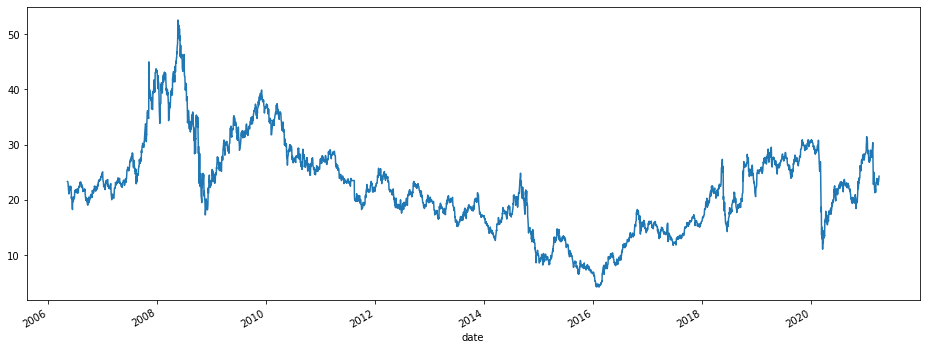

In [6]:
dataset_se['val_open'].plot(figsize=(16,6))

<AxesSubplot:xlabel='date'>

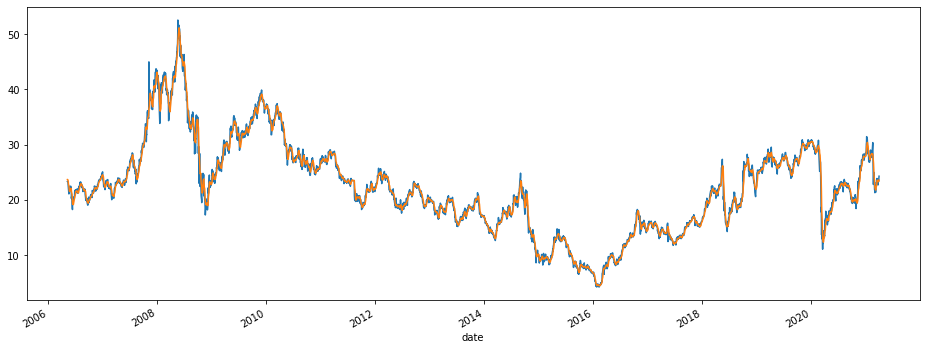

In [7]:
# Moving average of 7 days
dataset_se['val_open'].plot(figsize=(16,6))
dataset_se['Moving average 7'].plot()

<AxesSubplot:xlabel='date'>

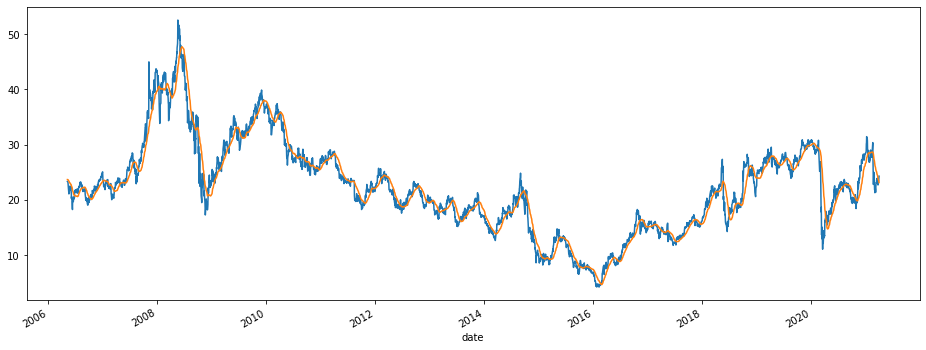

In [8]:
# Moving average of 30 days
dataset_se['val_open'].plot(figsize=(16,6))
dataset_se['Moving average 30'].plot()

## Naive Decisions

Let's create a commonly used naive comparative model. Its buying signals will be defined when the short-term moving average is lower than the long-term moving average and this ratio exceeds a threshold of 5%. The same is true for the sell signal, but considering the higher short-term average.


In [9]:
BUY_SIGNAL = "buy"
SELL_SIGNAL = "sell"

def buying_and_selling_moving_average(dataset, col_stock_price, col_average_7, col_average_30):
    _buying_selling_rate = 0.2 # Taxa de compra/venda em momentos de decisão
    _decision_threshold = 0.05 # Teto/limiar de decisão
    _op_buying = BUY_SIGNAL
    _op_selling = SELL_SIGNAL

    stock_units = 1000 # Quantitade de ativos inicial
    prices = []
    operations = []
    units = []
    date = []
    
    for index, row in dataset.iterrows():
        decision_evaluation = row[col_average_7] / row[col_average_30]
        #print(f'AV7: {row[col_average_7]},\nAV30: {row[col_average_30]},\nDE: {decision_evaluation}\n\n')

        if (decision_evaluation<1 and (-decision_evaluation+1) > _decision_threshold): # (média 7 dias % < média 30) → compro
            buying_units = round(_buying_selling_rate*stock_units)

            date.append(index)
            operations.append(_op_buying)
            prices.append(row[col_stock_price])
            units.append(buying_units)

            stock_units = stock_units + buying_units

        elif (decision_evaluation>1 and (decision_evaluation-1) > _decision_threshold): #  (média 7 dias % > média 30) → vendo
            selling_units = round(_buying_selling_rate*stock_units)

            date.append(index)
            operations.append(_op_selling)
            prices.append(row[col_stock_price])
            units.append(selling_units)

            stock_units = stock_units + selling_units

    df_buying_and_selling = pd.DataFrame({'date': date,
                                          'value_to_operate': prices,
                                          'signal': operations})
    df_buying_and_selling.set_index('date',inplace=True)
    
    return df_buying_and_selling


df = buying_and_selling_moving_average(dataset_se, 'val_open', 'Moving average 7', 'Moving average 30')


In [10]:
import math

COLUMN_TO_OPERATE = "value_to_operate"

def create_positions(df, initial_capital=10000, percentage_to_operate=0.05):
    position = {}
    current_capital = initial_capital
    for index, row in df.iterrows():
        capital_to_operate = current_capital*percentage_to_operate
        if row[SIGNAL_COLUMN] == BUY_SIGNAL and capital_to_operate > row[COLUMN_TO_OPERATE]:
            # print(f"capital_to_operate: {capital_to_operate}\nprice: {row[COLUMN_TO_OPERATE]}")
            
            amount = math.floor(capital_to_operate/row[COLUMN_TO_OPERATE])
            total = row[COLUMN_TO_OPERATE]*amount
            position[index] = {
                "type": BUY_SIGNAL,
                "amount": amount,
                "price": total
            }

            current_capital -= total
        if row[SIGNAL_COLUMN] == SELL_SIGNAL and has_open_position(position):
            amount = min(math.floor(get_amount_open_position(position) * percentage_to_operate), get_open_position(position))
            total = row[COLUMN_TO_OPERATE]*amount
            # print(f"selling {amount} with avg_price {avg_price}")

            position[index] = {
                "type": SELL_SIGNAL,
                "amount": amount,
                "price": total
            }

            current_capital += total

    return position


In [11]:
SIGNAL_COLUMN = "signal"
NEUTRAL_SIGNAL = "neutral"

def analyze_interval(df, index, shift, ignore_first_numbers=3, column_predicted="predicted", difference_percentage=0.05):
    should_ignore = True
    
    df[SIGNAL_COLUMN] = NEUTRAL_SIGNAL
    
    indexes_to_buy = set()
    indexes_to_sell = set()

    for index, row in df.iterrows():
        if row[column_predicted] != 0:
            if not should_ignore:
                current_indexes_to_buy, current_indexes_to_sell = create_signals_index(df[index:].iloc[:shift], column_predicted, difference_percentage, SIGNAL_COLUMN)
                indexes_to_buy = indexes_to_buy.union(set(current_indexes_to_buy))
                indexes_to_sell = indexes_to_sell.union(set(current_indexes_to_sell))
            else:
                ignore_first_numbers -= 1
                if ignore_first_numbers == 0:
                    should_ignore = False
    # print(indexes_to_sell)
    print(f"Number of operations\nBuy: {len(indexes_to_buy)}\nSell: {len(indexes_to_sell)}")
    df.loc[df.index.isin(indexes_to_buy), SIGNAL_COLUMN] = BUY_SIGNAL
    df.loc[df.index.isin(indexes_to_sell), SIGNAL_COLUMN] = SELL_SIGNAL

In [12]:
def get_open_position(position):
    amount = 0
    
    for key in position.keys():
        if position[key].get("type") == BUY_SIGNAL:
            amount += position[key].get("amount")
        
        if position[key].get("type") == SELL_SIGNAL:
            amount -= position[key].get("amount")
    return amount

def has_open_position(position):
    return get_open_position(position) > 0

def get_amount_open_position(position):
    amount = 0
    for key in position.keys():
        if position[key].get("type") == BUY_SIGNAL:
            amount += position[key].get("amount")
    return amount

In [13]:
def get_total_price(position, type):
    total = 0
    amount = 0
    for key in position.keys():
        if position[key].get("type") == type:
            total += position[key].get("price")
            amount += position[key].get("amount")
    return total, amount

def get_profit(position):
    total_buy_price, amount_buy = get_total_price(position, BUY_SIGNAL)
    total_sell_price, amount_sell = get_total_price(position, SELL_SIGNAL)

    profit = total_sell_price - total_buy_price
    avg_buy_price = total_buy_price/amount_buy if amount_buy > 0 else 0
    avg_sell_price = total_sell_price/amount_sell if amount_sell > 0 else 0

    return profit, avg_buy_price, avg_sell_price

In [14]:
def create_index_to_plot(df, signal):
    signals_index = []
    count = 0

    for index, row in df.iterrows():
        if row[SIGNAL_COLUMN] == signal:
            signals_index.append(count)
        count += 1
    return signals_index

## Evaluating the naive signs

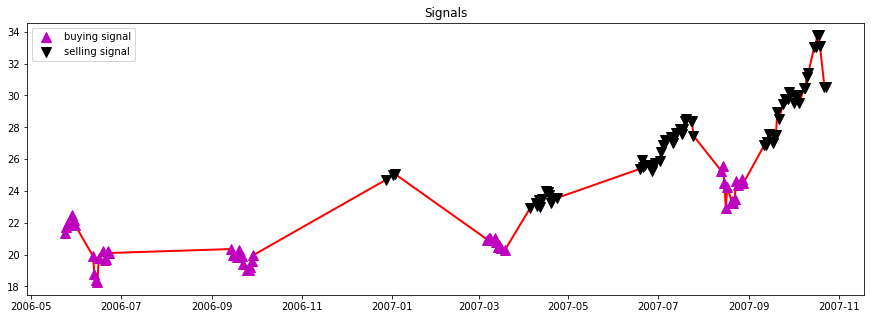

In [15]:
data_to_evaluate = df.iloc[:30*4]
signals_buy_index = create_index_to_plot(data_to_evaluate, BUY_SIGNAL)
signals_sell_index = create_index_to_plot(data_to_evaluate, SELL_SIGNAL)

fig = plt.figure(figsize = (15,5))
plt.plot(data_to_evaluate["value_to_operate"], color='r', lw=2.)
plt.plot(data_to_evaluate["value_to_operate"], '^', markersize=10, color='m', label = 'buying signal', markevery =signals_buy_index)
plt.plot(data_to_evaluate["value_to_operate"], 'v', markersize=10, color='k', label = 'selling signal', markevery = signals_sell_index)

plt.title('Signals')
plt.legend()
plt.show()

In [16]:
initial_capital=10000

position = create_positions(data_to_evaluate, initial_capital=initial_capital, percentage_to_operate=0.05)

In [17]:
current_profit, current_avg_buy_price, current_avg_sell_price = get_profit(position)
current_profit

2317.400000000007

## Using an RNN model with LSTM

In [18]:
from pre_process_data import DataModeling

In [91]:
rules = {
    "global": ["norm"],
    "data-set-proportion": {
        "train": 0.90,
        "train-validation": 0.15,
    }
}

In [92]:
features_cols = ['val_high','volume','Moving average 7','Moving average 30', 'Momentum 7']
target_col ='val_close'

data_modeling = DataModeling(dataset_se, features_cols, target_col, rules, input_width=30, label_width=30, shift=7)

## Exploring normalized data

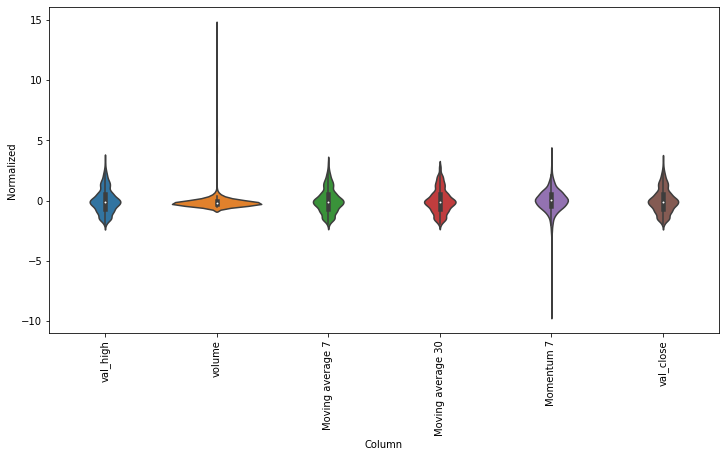

In [93]:
import seaborn as sns

data_to_plot = data_modeling.window_data.train_scaled

df_std = data_to_plot.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(data_to_plot.keys(), rotation=90)

## Working with WindowGenerator with shift 7

In [94]:
from lstm import LSTMModel

wide_window = data_modeling.window

model = LSTMModel()

In [95]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', model.regressor(wide_window.example[0]).shape)

Input shape: (32, 30, 6)
Output shape: (32, 30, 1)


In [96]:
val_performance = {}
performance = {}

history = model.compile_and_fit(wide_window)

Epoch 1/10
86/86 [==============================] - 15s 62ms/step - loss: 0.4505 - mean_absolute_error: 0.4687 - val_loss: 0.0866 - val_mean_absolute_error: 0.2240
Epoch 2/10
86/86 [==============================] - 3s 38ms/step - loss: 0.1499 - mean_absolute_error: 0.2575 - val_loss: 0.0740 - val_mean_absolute_error: 0.2041
Epoch 3/10
86/86 [==============================] - 3s 38ms/step - loss: 0.1110 - mean_absolute_error: 0.2214 - val_loss: 0.0619 - val_mean_absolute_error: 0.1801
Epoch 4/10
86/86 [==============================] - 3s 35ms/step - loss: 0.0869 - mean_absolute_error: 0.2006 - val_loss: 0.0599 - val_mean_absolute_error: 0.1814
Epoch 5/10
86/86 [==============================] - 3s 34ms/step - loss: 0.0740 - mean_absolute_error: 0.1876 - val_loss: 0.0506 - val_mean_absolute_error: 0.1627
Epoch 6/10
86/86 [==============================] - 3s 33ms/step - loss: 0.0670 - mean_absolute_error: 0.1800 - val_loss: 0.0525 - val_mean_absolute_error: 0.1671
Epoch 7/10
86/86 [===

## Plotting model predict and eval performance

In [97]:
print(history.history.keys())
print(f"loss: {history.history['loss'][::-1][0]}")
print(f"mean_absolute_error: {history.history['mean_absolute_error'][::-1][0]}")
print(f"val_loss: {history.history['val_loss'][::-1][0]}")
print(f"val_mean_absolute_error: {history.history['val_mean_absolute_error'][::-1][0]}")


dict_keys(['loss', 'mean_absolute_error', 'val_loss', 'val_mean_absolute_error'])
loss: 0.047442592680454254
mean_absolute_error: 0.15898127853870392
val_loss: 0.04792942479252815
val_mean_absolute_error: 0.16070005297660828


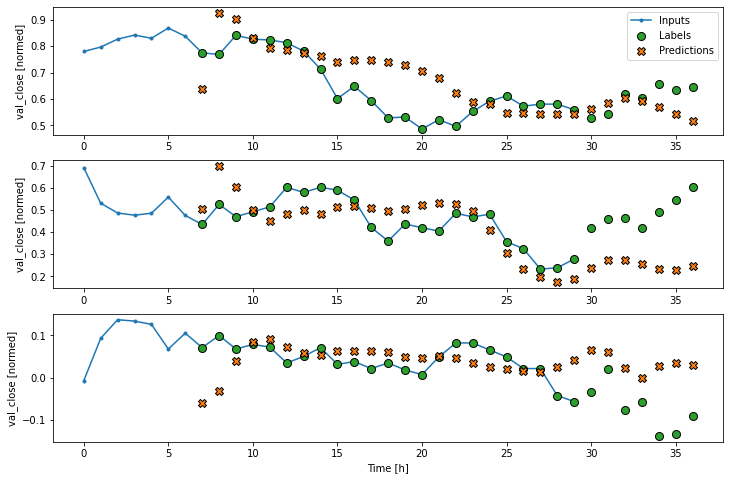

In [98]:
wide_window.plot(plot_col=target_col, model=model.regressor)

In [99]:
val_performance['LSTM'] = model.regressor.evaluate(wide_window.val, verbose=0)
performance['LSTM'] = model.regressor.evaluate(wide_window.test)

11/11 [==============================] - 0s 8ms/step - loss: 0.0937 - mean_absolute_error: 0.2153


## Estimating IA profit

In [100]:
def is_approximate_values(f_value, s_value):
    return math.isclose(f_value, s_value, rel_tol=1e-6)

In [101]:
def get_equivalent_data(df, values):
    values_length = len(values)
    for index, row in df.iterrows():
        if is_approximate_values(row[target_col], values[0]):
            if all_next_elements_equals(df[index:], values):
                return df[index:].iloc[0:values_length+7]
                
    return None


In [102]:
def all_next_elements_equals(df, values):
    i = 0
    for index, row in df.iterrows():
        if i == len(values):
            return True

        if not is_approximate_values(row[target_col], values[i]):
            return False
        i += 1
    return False

In [103]:
def test_plot(plot_col, data_modeling, inverse_process_func, intervals_to_analysis=4, model=None):
        dfs_positional = []

        inputs, labels = next(iter(wide_window.test))

        inputs_unscaleds = inverse_process_func(data_modeling.window_data.train_stats, inputs)
        labels_unscaleds = inverse_process_func(data_modeling.window_data.train_stats, labels)

        plt.figure(figsize=(12, 8))

        plot_col_index = wide_window.column_indices[plot_col]
        max_n = min(intervals_to_analysis, len(inputs))

        for n in range(max_n):
            df_equivalent = get_equivalent_data(wide_window.test_df, inputs[n, :, plot_col_index])[[plot_col]]

            input_indices = list(df_equivalent.index)[:len(list(df_equivalent.index))-wide_window.shift]
            label_indices = list(df_equivalent.index)[wide_window.shift:]
            
            plt.subplot(max_n, 1, n+1)
            plt.ylabel(f'{plot_col} [normed]')
            plt.plot(input_indices, inputs_unscaleds[n, :, plot_col_index],
                    label='Inputs', marker='.', zorder=-10)

            if wide_window.label_columns:
                label_col_index = wide_window.label_columns_indices.get(plot_col, None)
            else:
                label_col_index = plot_col_index

            if label_col_index is None:
                continue
            
            plt.scatter(label_indices, labels_unscaleds[n, :, label_col_index],
                        edgecolors='k', label='Labels', c='#2ca02c', s=64)


            if model is not None:
                predictions = model(inputs)

                predictions_unscaleds = inverse_process_func(data_modeling.window_data.train_stats, predictions)
                df_equivalent[plot_col] = np.concatenate((np.zeros(7), np.array(labels_unscaleds[n, :, label_col_index])), axis=0)
                dfs_positional.append(df_equivalent)

                dfs_positional[n]["predicted"] = np.concatenate((np.zeros(7), np.array(predictions_unscaleds[n, :, label_col_index])), axis=0)

                plt.scatter(label_indices, predictions_unscaleds[n, :, label_col_index],
                            marker='X', edgecolors='k', label='Predictions',
                            c='#ff7f0e', s=64)

            if n == 0:
                plt.legend()

        plt.xlabel('Time [d]')
        return dfs_positional

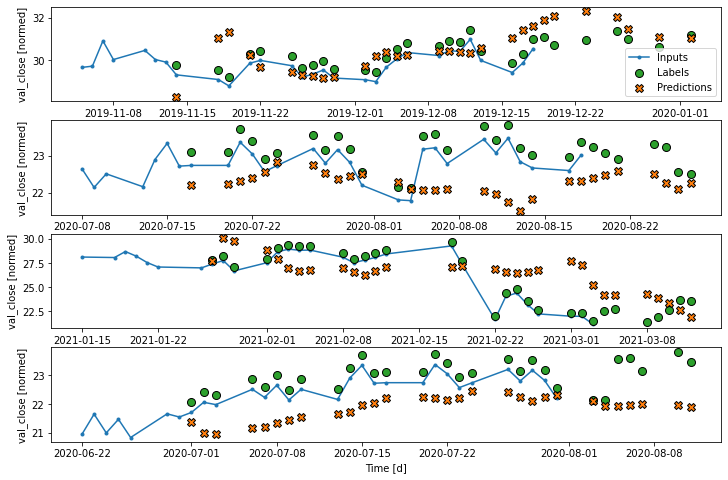

In [104]:
dfs_positional = test_plot(target_col, data_modeling, DataModeling.inverse_norm, model=model.regressor)

In [105]:
for df_positional in dfs_positional:
    df_positional["value_to_operate"] = dataset_se.loc[df_positional.index][target_col]

dfs_positional[1].head()

,val_close,predicted,value_to_operate
date,,,
2020-07-08,0.0,0.0,22.65
2020-07-09,0.0,0.0,22.14
2020-07-10,0.0,0.0,22.51
2020-07-13,0.0,0.0,22.16
2020-07-14,0.0,0.0,22.90


In [106]:
def create_signals_index(df, column_predicted, difference_percentage, SIGNAL_COLUMN):
    
    indexes_to_buy = []
    indexes_to_sell = []

    for current_index, current in df.iterrows():
        for future_index, future in df.loc[current_index:].iloc[1:].iterrows():
            if is_signal_to_buy(current[column_predicted], future[column_predicted], difference_percentage):
                # print(f"Buy on date {current_index}(R${current[column_predicted]}) because future date {future_index}(R${future[column_predicted]})")
                indexes_to_buy.append(current_index)
            else:
                if is_signal_to_sell(current[column_predicted], future[column_predicted], difference_percentage):
                    # print(f"Sell on date {current_index}(R${current[column_predicted]}) because future date {future_index}(R${future[column_predicted]})")
                    indexes_to_sell.append(current_index)

    return indexes_to_buy, indexes_to_sell
    
def is_signal_to_buy(current_value, future_value, difference_percentage):
    return (1 - current_value/future_value) >= difference_percentage

def is_signal_to_sell(current_value, future_value, difference_percentage):
    return (current_value/future_value - 1) >= difference_percentage

In [107]:
analyze_interval(dfs_positional[0], SIGNAL_COLUMN, wide_window.shift)

Number of operations
Buy: 2
Sell: 0


In [108]:
initial_capital=10000

position = create_positions(dfs_positional[0], initial_capital=initial_capital, percentage_to_operate=0.05)

In [109]:
get_total_price(position, BUY_SIGNAL)

(945.22, 31)

In [110]:
get_total_price(position, SELL_SIGNAL)

(0, 0)

In [111]:
profit, avg_buy_price, avg_sell_price = get_profit(position)
print(f"Profit: {profit}\nAvgBuyPrice: {avg_buy_price}\nAvgSellPrice:{avg_sell_price}\n\n")

Profit: -945.22
AvgBuyPrice: 30.490967741935485
AvgSellPrice:0




In [112]:
def concat_positions(first_position, second_position):
    for key in second_position.keys():
        first_position[key] = second_position[key]

Number of operations
Buy: 2
Sell: 0


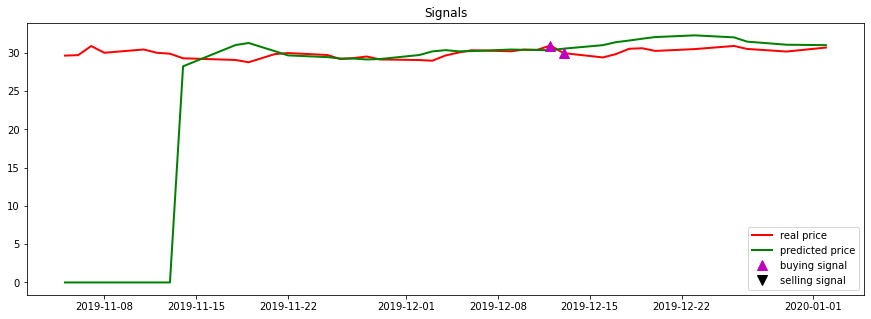

Number of operations
Buy: 0
Sell: 0


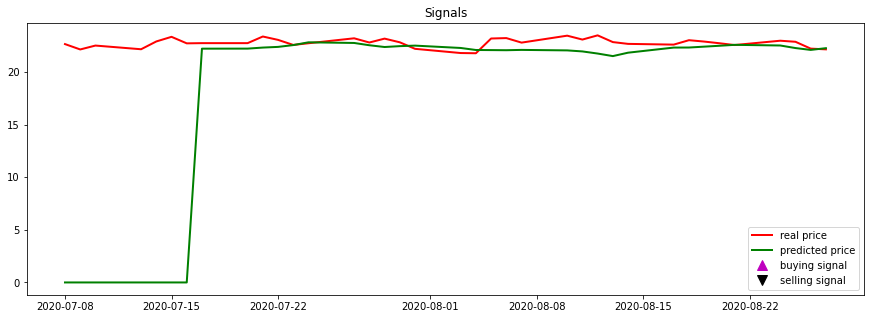

Number of operations
Buy: 0
Sell: 14


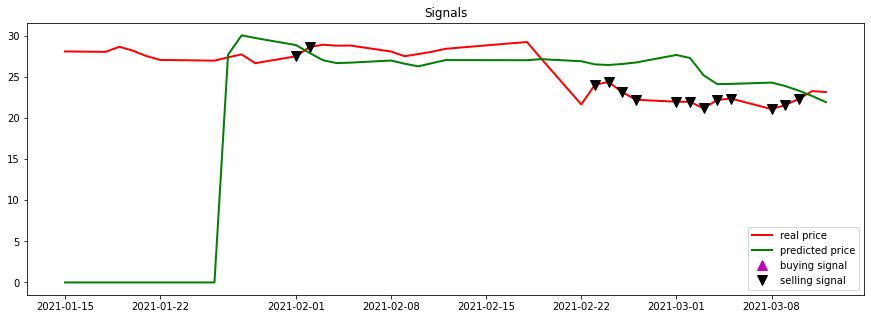

Number of operations
Buy: 0
Sell: 0


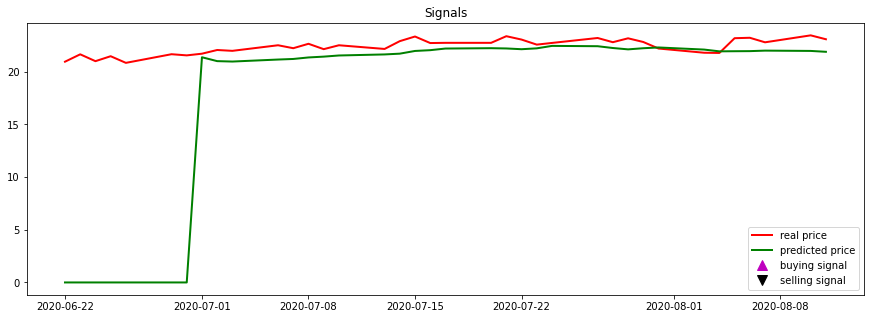

In [114]:
profit = 0
position = {}

for df in dfs_positional:
    analyze_interval(df, SIGNAL_COLUMN, wide_window.shift)
    current_position = create_positions(df, initial_capital=initial_capital, percentage_to_operate=0.05)

    concat_positions(position, current_position)

    current_profit, current_avg_buy_price, current_avg_sell_price = get_profit(position)
    profit += current_profit
    
    signals_buy_index = create_index_to_plot(df, BUY_SIGNAL)
    signals_sell_index = create_index_to_plot(df, SELL_SIGNAL)

    fig = plt.figure(figsize = (15,5))
    plt.plot(df["value_to_operate"], color='r', label = 'real price', lw=2.)
    plt.plot(df["predicted"], color='g', label = 'predicted price', lw=2.)
    plt.plot(df["value_to_operate"], '^', markersize=10, color='m', label = 'buying signal', markevery =signals_buy_index)
    plt.plot(df["value_to_operate"], 'v', markersize=10, color='k', label = 'selling signal', markevery = signals_sell_index)

    plt.title('Signals')
    plt.legend()
    plt.show()

price_buy, amount_buy = get_total_price(position, BUY_SIGNAL)
price_sell, amount_sell = get_total_price(position, SELL_SIGNAL)

avg_buy_price = price_buy/amount_buy if amount_buy != 0 else 0
avg_sell_price = price_sell/amount_sell if amount_sell != 0 else 0


In [115]:
profit, avg_buy_price, avg_sell_price

(-3780.88, 30.490967741935485, 0)

Given the time interval worked, the model that elaborates buy and sell signals based on future predictions generated a high loss for the group worked.

While the naive method using the same features generated profit in their samples with the same time interval.